
## Matches DESI observations to DECam to get a redshift

This code predominately takes in data from the ALERCE and DECAM ledger brokers and identifies the closest DESI galaxy within 4 arcseconds of those objects, suspected to be transients. 

The main matching algorithm uses astropy's **match_coordinate_sky** to match 1-to-1 targets with the objects from the two ledgers. Wrapping functions handle data retrieval from both the ledgers as well as from DESI and prepare this data to be fed into **match_coordinate_sky**. Since ALERCE returns a small enough (pandas) dataframe, we do not need to precondition the input much. However, DECAM has many more objects to match so we use a two-stage process: an initial 2 degree match to tile RA's/DEC's and a second closer 1 arcsecond match to individual targets. 


In [1]:
from astropy.io import fits
from astropy.table import Table
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, match_coordinates_sky, Angle


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import sys

import sqlite3
import os

from desispec.io import read_spectra, write_spectra
from desispec.spectra import Spectra

# Some handy global variables
global db_filename
db_filename = '/global/cfs/cdirs/desi/science/td/daily-search/transients_search.db'
global exposure_path
exposure_path = os.environ["DESI_SPECTRO_REDUX"]
global color_band
color_band = "r"

global today
today = Time.now()

In [2]:

def plt_style():
    plt.rcParams.update({
                        'lines.linewidth':1.0,
                        'lines.linestyle':'-',
                        'lines.color':'black',
                        'font.family':'serif',
                        'font.weight':'normal',
                        'font.size':13.0,
                        'text.color':'black',
                        'text.usetex':True,
                        'axes.edgecolor':'black',
                        'axes.linewidth':1.0,
                        'axes.grid':False,
                        'axes.titlesize':'x-large',
                        'axes.labelsize':'x-large',
                        'axes.labelweight':'normal',
                        'axes.labelcolor':'black',
                        'axes.formatter.limits':[-4,4],
                        'xtick.major.size':7,
                        'xtick.minor.size':4,
                        'xtick.major.pad':8,
                        'xtick.minor.pad':8,
                        'xtick.labelsize':'medium',
                        'xtick.minor.width':1.0,
                        'xtick.major.width':1.0,
                        'ytick.major.size':7,
                        'ytick.minor.size':4,
                        'ytick.major.pad':8,
                        'ytick.minor.pad':8,
                        'ytick.labelsize':'medium',
                        'ytick.minor.width':1.0,
                        'ytick.major.width':1.0,
                        'legend.numpoints':1,
                        #'legend.fontsize':'x-large',
                        'legend.shadow':False,
                        'legend.frameon':False})


# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)





## Necessary functions

In [3]:
# From https://github.com/desihub/timedomain/blob/master/too_ledgers/decam_TAMU_ledgermaker.ipynb
# Function to grab decam data
from bs4 import BeautifulSoup
import json
import requests
def access_decam_data(url, overwrite=False):
    """Download reduced DECam transient data from Texas A&M.
    Cache the data to avoid lengthy and expensive downloads.
    
    Parameters
    ----------
    url : str
        URL for accessing the data.
    overwrite : bool
        Download new data and overwrite the cached data.
        
    Returns
    -------
    decam_transients : pandas.DataFrame
        Table of transient data.
    """
    folders = url.split('/')
    thedate = folders[-1] if len(folders[-1]) > 0 else folders[-2]
    outfile = '{}.csv'.format(thedate)
    
    if os.path.exists(outfile) and not overwrite:
        # Access cached data.
        decam_transients = pd.read_csv(outfile)
    else:
        # Download the DECam data index.
        # A try/except is needed because the datahub SSL certificate isn't playing well with URL requests.
        try:
            decam_dets = requests.get(url, auth=('decam','tamudecam')).text
        except:
            requests.packages.urllib3.disable_warnings(requests.packages.urllib3.exceptions.InsecureRequestWarning)
            decam_dets = requests.get(url, verify=False, auth=('decam','tamudecam')).text
            
        # Convert transient index page into scrapable data using BeautifulSoup.
        soup = BeautifulSoup(decam_dets)
        
        # Loop through transient object summary JSON files indexed in the main transient page.
        # Download the JSONs and dump the info into a Pandas table.
        decam_transients = None
        j = 0

        for a in soup.find_all('a', href=True):
            if 'object-summary.json' in a:
                link = a['href'].replace('./', '')
                summary_url  = url + link        
                summary_text = requests.get(summary_url, verify=False, auth=('decam','tamudecam')).text
                summary_data = json.loads(summary_text)

                j += 1
                #print('Accessing {:3d}  {}'.format(j, summary_url)) # Modified by Matt

                if decam_transients is None:
                    decam_transients = pd.DataFrame(summary_data, index=[0])
                else:
                    decam_transients = pd.concat([decam_transients, pd.DataFrame(summary_data, index=[0])])
                    
        # Cache the data for future access.
        print('Saving output to {}'.format(outfile))
        decam_transients.to_csv(outfile, index=False)
        
    return decam_transients

In [4]:
# Function to read in fits table info, RA, DEC, MJD and targetid if so desired
# Uses control parameter tile to determine if opening tile exposure file or not since headers are different

def read_fits_info(filepath: str):
    try:
        h=fits.open(filepath)
        #targ_mjd = data_table['MJD'][0] some have different versions of this so this is a *bad* idea... at least now I know the try except works!
        targ_ra, targ_dec = h[2].data['target_RA'],h[2].data['target_DEC']
        targ_id = h[2].data['TARGETID'].astype(int)
        targ_id_z = h[1].data['TARGETID']
        targ_z = h[1].data['Z']
        targ_spectype = h[1].data['SPECTYPE']
        targ_zwarn = h[1].data['ZWARN']
        targ_chi2 = h[1].data['DELTACHI2']
            
    except:
        filename = filepath.split("/")[-1]
        print("Could not open or use:", filename)
        print("In path:", filepath)
        print("Trying the next file...")
        return np.array([]), np.array([]), np.array([])
    
    return targ_ra, targ_dec, targ_id, targ_z, targ_spectype, targ_zwarn, targ_chi2

## Matching to DECAM functions

In [5]:
# Grabbing the frame fits files
def glob_frames(exp_d: str):    
    # This function grabs the names of all input files in the transient directory and does some python string manipulation
    # to grab the names of the input files with full path and the filenames themselves.

    try:
        filenames_read = glob.glob(exp_d + "/redrock-*.fits") # Only need one of b, r, z
        # sframes not flux calibrated
        # May want to use tiles... coadd (will need later, but not now)
    
    except:
        print("Could not grab/find any fits in the exposure directory:")
        print(exp_d)
        filenames_read = [] # Just in case
        #filenames_out = [] # Just in case
        raise SystemExit("Exiting.")
        
    #else:
        #filenames_out = [s.split(".")[0] for s in filenames_read]
        #filenames_out = [s.split("/")[-1] for s in filenames_read]
        #filenames_out = [s.replace("in", "out") for s in filenames_out]
        
    return filenames_read #, filenames_out

#path_to_transient = "/global/cfs/cdirs/desi/science/td/daily-search/desitrip/out"
#print(all_candidate_filenames(path_to_transient)[1])

## Grab DECAM ledger as pandas dataframe

In [6]:
decam_transients = access_decam_data('https://datahub.geos.tamu.edu:8000/decam/LCData_Legacy/', overwrite = False) # If True, grabs a fresh batch

In [7]:
decam_transients_agn = access_decam_data('https://datahub.geos.tamu.edu:8000/decam/LCData_Legacy_AGN/', overwrite = False) # If True, grabs a fresh batch

In [8]:
decam_transients

,ObjectID,RA-OBJECT,DEC-OBJECT,NumberAlerts,MaxSCORE,RA-PSEUDO-HOST,DEC-PSEUDO-HOST,SEP-PSEUDO-HOST,RA-NEIGHBOR-STAR,DEC-NEIGHBOR-STAR,...,Discovery-Round,Discovery-Time,Discovery-Filter,Discovery-Magnitude,Discovery-SNR,Latest-Round,Latest-Time,Latest-Filter,Latest-Magnitude,Latest-SNR
0,A202103221407558m001825,211.982786,-0.306951,12,0.972,211.982614,-0.306946,0.6199,211.983372,-0.306315,...,0,2021-03-22T06:40:19.074,N,22.13,19.2,9,2021-04-18T05:37:55.763,N,22.86,10.2
1,A202103221408139m033502,212.057952,-3.583947,28,0.954,212.057864,-3.583960,0.3199,212.058798,-3.586276,...,0,2021-03-22T08:20:58.209,N,21.78,25.7,23,2021-06-02T06:00:51.873,N,21.82,18.1
2,A202103221408412p002445,212.171737,0.412527,49,0.998,212.171673,0.412394,0.5317,212.174697,0.411566,...,0,2021-03-22T06:36:50.928,S,20.61,36.2,23,2021-06-02T02:59:21.867,S,21.46,33.9
3,A202103221408578m005300,212.241200,-0.883300,2,0.855,212.241200,-0.883400,0.3000,212.239800,-0.884900,...,0,2021-03-22T08:17:30.880,S,22.55,15.5,1,2021-03-24T07:10:51.368,S,22.33,25.6
4,A202103221409059m023156,212.274757,-2.532478,21,0.969,212.274533,-2.532531,0.8290,212.275356,-2.535003,...,0,2021-03-22T08:14:02.747,N,22.27,10.6,18,2021-05-18T03:17:17.544,N,22.99,8.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,T202106021437535m004239,219.473273,-0.710944,6,0.973,219.473277,-0.711253,1.1100,219.473195,-0.714488,...,23,2021-06-02T02:37:33.855,N,21.46,30.6,24,2021-06-05T02:15:30.763,N,21.44,19.8
553,T202106021440559m025615,220.233290,-2.937658,4,0.940,220.233839,-2.935933,6.5148,220.230799,-2.938535,...,23,2021-06-02T05:33:59.097,S,22.14,13.6,23,2021-06-02T05:40:21.261,S,22.36,14.0
554,T202106021442286m035936,220.619578,-3.993391,3,0.935,220.618952,-3.993328,2.2614,220.615993,-3.991748,...,23,2021-06-02T05:33:59.097,N,22.15,22.5,23,2021-06-02T05:36:54.041,N,22.07,10.5
555,T202106021449003p003225,222.251305,0.540528,7,0.984,222.251090,0.540740,1.0845,222.249251,0.544256,...,23,2021-06-02T02:27:20.976,S,21.04,47.1,24,2021-06-05T02:06:24.397,S,21.21,18.4


In [9]:
#Match w Fuji, Guandalupe, and daily from Jul 6 2021
import healpy as hp

nside = 64
nest = True

#Define hpixs of transients

hpix_hosts = hp.ang2pix(nside, np.array(decam_transients['RA-PSEUDO-HOST']),np.array(decam_transients['DEC-PSEUDO-HOST']),
                        lonlat=True, nest = nest )
hpix_hosts_agn = hp.ang2pix(nside, np.array(decam_transients_agn['RA-PSEUDO-HOST']),np.array(decam_transients_agn['DEC-PSEUDO-HOST']),
                        lonlat=True, nest = nest )

hosts_coords = SkyCoord(decam_transients['RA-PSEUDO-HOST']*u.deg, decam_transients['DEC-PSEUDO-HOST']*u.deg)
hosts_coords_agn = SkyCoord(decam_transients_agn['RA-PSEUDO-HOST']*u.deg, decam_transients_agn['DEC-PSEUDO-HOST']*u.deg)

In [10]:
hpix_hosts_un = np.unique(hpix_hosts)
#Create array to store redshifts. If no redshift available, it will say -9
zhosts = np.full(decam_transients['RA-PSEUDO-HOST'].shape[0], -9, dtype=float)
ztype = np.full(decam_transients['RA-PSEUDO-HOST'].shape[0], 'NULL', dtype='<U6' )
zwarn = np.full(decam_transients['RA-PSEUDO-HOST'].shape[0], -9)
zchi = np.full(decam_transients['RA-PSEUDO-HOST'].shape[0], -9)
transid = np.full(decam_transients['RA-PSEUDO-HOST'].shape[0], 'NULL', dtype='<U40' )
desiids = np.full(decam_transients['RA-PSEUDO-HOST'].shape[0], -9, dtype='int' )

hpix_hosts_un_agn = np.unique(hpix_hosts_agn)
#Create array to store redshifts. If no redshift available, it will say -9
zhosts_agn = np.full(decam_transients_agn['RA-PSEUDO-HOST'].shape[0], -9, dtype=float)
ztype_agn = np.full(decam_transients_agn['RA-PSEUDO-HOST'].shape[0], 'NULL', dtype='<U6' )
zwarn_agn = np.full(decam_transients_agn['RA-PSEUDO-HOST'].shape[0], -9)
zchi_agn = np.full(decam_transients_agn['RA-PSEUDO-HOST'].shape[0], -9)
transid_agn = np.full(decam_transients_agn['RA-PSEUDO-HOST'].shape[0], 'NULL', dtype='<U40' )
desiids_agn = np.full(decam_transients_agn['RA-PSEUDO-HOST'].shape[0], -9, dtype='int' )

In [11]:
redux = ['fuji', 'guandalupe'] #Add daily

base_dir_path = '/global/cfs/cdirs/desi/spectro/redux/'
surveys=['main', 'sv1', 'sv2', 'sv3']
times=['bright','dark']

max_sep = 2 * u.arcsec

for this_redux in redux:
    base_dir = base_dir_path + this_redux + '/healpix/'
    for survey in surveys:
        print("Checking survey: ",this_redux," ", survey)
        for time in times:
            print("Checking ", time, " time")
            nmatches=0
            for hpix_host in hpix_hosts_un:
                filepath = base_dir+survey+'/'+time+'/'+str(hpix_host)[:-2]+\
                '/'+str(hpix_host)+'/'+'redrock-*fits'
                filename = glob.glob(filepath)
                try:
                    h=fits.open(filename[0])
                    #print("Opened file", filename)
                    desi_ra, desi_dec = h[2].data['target_RA'],h[2].data['target_DEC']
                    desi_id = h[2].data['TARGETID']
                    desi_id_z = h[1].data['TARGETID']
                    desi_z = h[1].data['Z']
                    desi_spectype = h[1].data['SPECTYPE']
                    desi_zwarn = h[1].data['ZWARN']
                    desi_chi2 = h[1].data['DELTACHI2']

                    # Convert everything to SkyCoord
                    desi_coords = SkyCoord(desi_ra*u.deg, desi_dec*u.deg)

                    idx_desi, d2d_trans, d3d_trans = match_coordinates_sky(hosts_coords,desi_coords)

                    # Filter out the good stuff
                    sep_constraint = d2d_trans < max_sep

                    if idx_desi[sep_constraint].shape[0] >0 : 
                        #print(idx_desi[sep_constraint].shape[0], " matches ")
                        nmatches += idx_desi[sep_constraint].shape[0]
                        hosts_matches = hosts_coords[sep_constraint]
                        #trans_matches_ids = target_ids_in[sep_constraint]
                        desi_matches = desi_coords[idx_desi[sep_constraint]]

                        transid[sep_constraint] = decam_transients['ObjectID'][sep_constraint]
                        desiids[sep_constraint] = desi_id[idx_desi[sep_constraint]]
                        zhosts[sep_constraint] = desi_z[idx_desi[sep_constraint]]
                        zchi[sep_constraint] = desi_chi2[idx_desi[sep_constraint]]
                        ztype[sep_constraint] = desi_spectype[idx_desi[sep_constraint]]
                        zwarn[sep_constraint] = desi_zwarn[idx_desi[sep_constraint]]

                    #CHECK TARGETID!!
                except:
                    test = 2
                    #print("No redrock file found") # for ", filepath)
                    
            print(nmatches, " matches ")

Checking survey:  fuji   main
Checking  bright  time
0  matches 
Checking  dark  time
0  matches 
Checking survey:  fuji   sv1
Checking  bright  time
5  matches 
Checking  dark  time
3  matches 
Checking survey:  fuji   sv2
Checking  bright  time
0  matches 
Checking  dark  time
0  matches 
Checking survey:  fuji   sv3
Checking  bright  time
136  matches 
Checking  dark  time
48  matches 
Checking survey:  guandalupe   main
Checking  bright  time
0  matches 
Checking  dark  time
0  matches 
Checking survey:  guandalupe   sv1
Checking  bright  time
0  matches 
Checking  dark  time
0  matches 
Checking survey:  guandalupe   sv2
Checking  bright  time
0  matches 
Checking  dark  time
0  matches 
Checking survey:  guandalupe   sv3
Checking  bright  time
0  matches 
Checking  dark  time
0  matches 


In [12]:
redux = ['fuji', 'guandalupe'] #Add daily

base_dir_path = '/global/cfs/cdirs/desi/spectro/redux/'
surveys=['main', 'sv1', 'sv2', 'sv3']
times=['bright','dark']

max_sep = 2 * u.arcsec

for this_redux in redux:
    base_dir = base_dir_path + this_redux + '/healpix/'
    for survey in surveys:
        print("Checking survey: ",this_redux," ", survey)
        for time in times:
            print("Checking ", time, " time")
            nmatches=0
            for hpix_host in hpix_hosts_un_agn:
                filepath = base_dir+survey+'/'+time+'/'+str(hpix_host)[:-2]+\
                '/'+str(hpix_host)+'/'+'redrock-*fits'
                filename = glob.glob(filepath)
                try:
                    h=fits.open(filename[0])
                    #print("Opened file", filename)
                    desi_ra, desi_dec = h[2].data['target_RA'],h[2].data['target_DEC']
                    desi_id = h[2].data['TARGETID']
                    desi_id_z = h[1].data['TARGETID']
                    #print(desi_id,desi_id_z)
                    desi_z = h[1].data['Z']
                    desi_spectype = h[1].data['SPECTYPE']
                    desi_zwarn = h[1].data['ZWARN']
                    desi_chi2 = h[1].data['DELTACHI2']

                    # Convert everything to SkyCoord
                    desi_coords = SkyCoord(desi_ra*u.deg, desi_dec*u.deg)

                    idx_desi, d2d_trans, d3d_trans = match_coordinates_sky(hosts_coords_agn,desi_coords)

                    # Filter out the good stuff
                    sep_constraint = d2d_trans < max_sep

                    if idx_desi[sep_constraint].shape[0] >0 : 
                        #print(idx_desi[sep_constraint].shape[0], " matches ")
                        nmatches += idx_desi[sep_constraint].shape[0]
                        hosts_matches = hosts_coords_agn[sep_constraint]
                        #trans_matches_ids = target_ids_in[sep_constraint]
                        desi_matches = desi_coords[idx_desi[sep_constraint]]
                        #desi_matches_ids = desi_id[idx_alerts[sep_constraint]]

                        transid_agn[sep_constraint] = decam_transients_agn['ObjectID'][sep_constraint]
                        desiids_agn[sep_constraint] = desi_id[idx_desi[sep_constraint]]
                        zhosts_agn[sep_constraint] = desi_z[idx_desi[sep_constraint]]
                        zchi_agn[sep_constraint] = desi_chi2[idx_desi[sep_constraint]]
                        ztype_agn[sep_constraint] = desi_spectype[idx_desi[sep_constraint]]
                        zwarn_agn[sep_constraint] = desi_zwarn[idx_desi[sep_constraint]]

                except:
                    test=-10
                #except Exception as e: 
                    #print(e)
                    #print("No redrock file found") # for ", filepath)

            print(nmatches, " matches ")
                

Checking survey:  fuji   main
Checking  bright  time
0  matches 
Checking  dark  time
0  matches 
Checking survey:  fuji   sv1
Checking  bright  time
0  matches 
Checking  dark  time
1  matches 
Checking survey:  fuji   sv2
Checking  bright  time
0  matches 
Checking  dark  time
0  matches 
Checking survey:  fuji   sv3
Checking  bright  time
41  matches 
Checking  dark  time
66  matches 
Checking survey:  guandalupe   main
Checking  bright  time
0  matches 
Checking  dark  time
0  matches 
Checking survey:  guandalupe   sv1
Checking  bright  time
0  matches 
Checking  dark  time
0  matches 
Checking survey:  guandalupe   sv2
Checking  bright  time
0  matches 
Checking  dark  time
0  matches 
Checking survey:  guandalupe   sv3
Checking  bright  time
0  matches 
Checking  dark  time
0  matches 


In [13]:
print("All transients and AGN hosts in Fujilupe: ",zhosts[(zhosts>-1) ].shape, zhosts_agn[(zhosts_agn>-1)].shape)
print("Transients and AGN hosts in Fujilupe: ",zhosts[(zhosts>-1) & (zwarn==0)].shape, zhosts_agn[(zhosts_agn>-1) & (zwarn_agn==0)].shape)

All transients and AGN hosts in Fujilupe:  (158,) (99,)
Transients and AGN hosts in Fujilupe:  (146,) (97,)


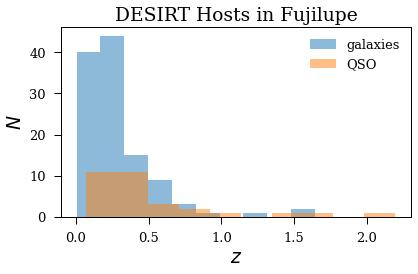

In [14]:
plt_style()
from matplotlib import rc
rc("text", usetex=False)

plt.hist(zhosts[(zhosts>-1) & (ztype=='GALAXY') & (zwarn==0)], label='galaxies',alpha=0.5)
plt.hist(zhosts[(zhosts>-1) & (ztype=='QSO') & (zwarn==0)], label='QSO',alpha=0.5)

plt.legend()
plt.ylabel('$N$')
plt.xlabel('$z$')
plt.title('DESIRT Hosts in Fujilupe')
plt.tight_layout()
plt.savefig('DESIRT_hosts_fujilupe_dndz.png',dpi=200)

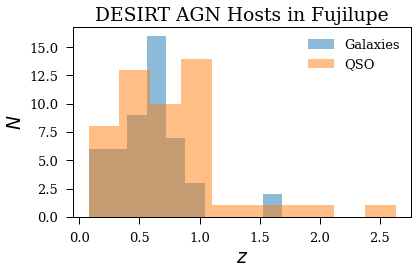

In [15]:
plt.hist(zhosts_agn[(zhosts_agn>-1) & (ztype_agn=='GALAXY') ], label='Galaxies',alpha=0.5)
plt.hist(zhosts_agn[(zhosts_agn>-1) & (ztype_agn=='QSO') ], label='QSO',alpha=0.5)

plt.legend()
plt.ylabel('$N$')
plt.xlabel('$z$')
plt.title('DESIRT AGN Hosts in Fujilupe')
plt.tight_layout()
plt.savefig('DESIRT_hosts_agn_fujilupe_dndz.png',dpi=200)

### Now match to daily exposures


In [16]:
def initial_check(ledger_df = None, ledger_type = ''):

    query_date_start = "20210606"
    
    #today = Time.now()
    smushed_YMD = today.iso.split(" ")[0].replace("-","")
    
    query_date_end = smushed_YMD 

    # Handy queries for debugging/useful info
    query2 = "PRAGMA table_info(exposures)"
    query3 = "PRAGMA table_info(tiles)"
    # Crossmatch across tiles and exposures to grab obsdate via tileid
    query_match = "SELECT distinct tilera, tiledec, exposures.tileid from exposures INNER JOIN tiles ON exposures.tileid = tiles.tileid where obsdate BETWEEN " + \
        query_date_start + " AND " + query_date_end + ";" 
    
    '''
    Some handy code for debugging
    #cur.execute(query2)
    #row2 = cur.fetchall()
    #for i in row2:
    #    print(i[:])

    '''
    
    # Querying sql and returning a data type called sqlite3 row, it's kind of like a namedtuple/dictionary
    conn = sqlite3.connect(db_filename)

    conn.row_factory = sqlite3.Row # https://docs.python.org/3/library/sqlite3.html#sqlite3.Row

    cur = conn.cursor()

    cur.execute(query_match)
    matches_list = cur.fetchall()
    cur.close()

    # I knew there was a way! THANK YOU!
    # https://stackoverflow.com/questions/11276473/append-to-a-dict-of-lists-with-a-dict-comprehension
    
    #alert_matches_dict = {}

    all_trans_matches = []
    all_alerts_matches = []
    
    # Grabbing DECAM ledger if not already fed in
    if ledger_type.upper() == 'DECAM_TAMU':
        if ledger_df.empty:
            ledger_df = access_decam_data('https://datahub.geos.tamu.edu:8000/decam/LCData_Legacy/')

    unique_tileid = {i['tileid']: (i['tilera'], i['tiledec']) for i in matches_list}
    tile_ras, tile_decs = zip(*unique_tileid.values())
    tileid_arr = np.array(list(unique_tileid.keys())) 

    # Where the magic/matching happens
    trans_matches, alert_matches, trans_ids, alerts_ids, _ = \
        inner_matching(target_ids_in = tileid_arr, target_ras_in = tile_ras, target_decs_in = tile_decs, 
        path_in = '', max_sep = 1.8, sep_units = 'deg', ledger_df_in = ledger_df, ledger_type_in = ledger_type)

    # Add everything into one giant list for both
    if trans_matches.size:
        #print(date, "-", len(trans_matches), "matches")
        all_trans_matches.append(trans_matches)
        all_alerts_matches.append(alert_matches)
        
    # Prepping output
    # Populating the dictionary by date (a common theme)
    # Each element in the dictionary thus contains the entire sqlite3 row (all info from sql tables with said headers)

    nmatches = trans_matches.shape[0]
    alert_matches_dict = {trans_ids[i]: (trans_matches[i].ra.deg, trans_matches[i].dec.deg) for i in range(nmatches)}

    return alert_matches_dict

In [17]:
def closer_check(matches_dict = {}, ledger_df = None, ledger_type = '', exclusion_list = [], agn=False):
    all_exp_matches = {}
        
    if not matches_dict:
        print("No far matches fed in for nearby matching. Returning none.")
        return {}
    
    # Again just in case the dataframe isn't fed in
    if ledger_type.upper() == 'DECAM_TAMU':
        
        id_head = 'ObjectID'
        ra_head = 'RA-PSEUDO-HOST'
        dec_head = 'DEC-PSEUDO-HOST'
        
        if ledger_df.empty:
            ledger_df = access_decam_data('https://datahub.geos.tamu.edu:8000/decam/LCData_Legacy/')
    
    count_flag=0
    tot_matches = 0
    # Iterating through date and all tile information for that date
    for tileid, row in matches_dict.items(): 
        # Declaring some things
        all_exp_matches = []
        alert_exp_matches = []
        file_indices = {}

        all_targ_ras = np.array([])
        all_targ_decs = np.array([])
        all_targ_ids = np.array([])
        all_tileids = np.array([])
        all_petals = np.array([])
        all_zhosts = np.array([])
        all_chi= np.array([])
        all_type= np.array([])
        all_zwarn= np.array([])


        # Grabbing the paths and iterating through them to grab the RA's/DEC's
        exp_paths = '/'.join((exposure_path, "daily/tiles/cumulative", str(tileid), "*/"))
        for path in glob_frames(exp_paths):
            #print(path)
            targ_ras, targ_decs, targ_ids, targ_z, targ_spectype, targ_zwarn, targ_chi2 = \
            read_fits_info(path)

            tileids = np.full(len(targ_ras),tileid).tolist()
            petal = path.split("/")[-1].split("-")[1][-1]
            petals = np.full(len(targ_ras),petal).tolist()

            # This is to retain the row to debug/check the original FITS file
            # And to pull the info by row direct if you feel so inclined
            all_len = len(all_targ_ras)
            new_len = len(targ_ras)
            if all_len:
                all_len -= 1
                file_indices[path] = (all_len, all_len + new_len) # The start and end index, modulo number
            else:
                file_indices[path] = (0, new_len) # The start and end index, modulo number

            if len(targ_ras) != len(targ_decs):
                print("Length of all ras vs. all decs do not match.")
                print("Something went wrong!")
                print("Continuing but not adding those to match...")
                continue

            # All the ras/decs together!
            all_targ_ras = np.append(all_targ_ras, targ_ras)
            all_targ_decs = np.append(all_targ_decs, targ_decs)
            all_targ_ids = np.append(all_targ_ids, targ_ids)
            all_tileids = np.append(all_tileids, tileids)
            all_petals = np.append(all_petals, petals)
            all_zhosts = np.append(all_zhosts, targ_z)
            all_type = np.append(all_type, targ_spectype)
            all_zwarn = np.append(all_zwarn, targ_zwarn)
            all_chi = np.append(all_chi, targ_chi2)
                
        # Checking for NaNs, again doesn't play nice with match_coordinates_sky
        nan_ra = np.isnan(all_targ_ras)
        nan_dec = np.isnan(all_targ_decs)
    
        if np.any(nan_ra) or np.any(nan_dec):
            print("NaNs found, removing them from array before match.")
            #print("Original length (ra, dec): ", len(target_ras), len(target_decs))
            nans = np.logical_not(np.logical_and(nan_ra, nan_dec))
            all_targ_ras = all_targ_ras[nans] # Logic masking, probably more efficient
            all_targ_decs = all_targ_decs[nans]
            all_targ_ids = all_targ_ids[nans]
            all_tileids = all_tileids[nans]
            all_petals = all_petals[nans]
        
        # Where the magic matching happens. This time with separation 2 arcseconds.
        # Will be cleaned up (eventually)
        alert_exp_matches, alerts_matches, targetid_exp_matches, id_alerts_matches, exp_idx = inner_matching(target_ids_in =all_targ_ids, \
                        target_ras_in = all_targ_ras, target_decs_in = all_targ_decs, \
                        path_in = '', max_sep = 2, sep_units = 'arcsec', ledger_df_in = ledger_df, ledger_type_in = ledger_type)   

        if alert_exp_matches != None:
            nmatches = targetid_exp_matches.shape[0]
            tot_matches +=nmatches
            #print(nmatches, "added")
            info_arr=np.column_stack((all_tileids[exp_idx],all_petals[exp_idx], targetid_exp_matches,alert_exp_matches.ra.deg,alert_exp_matches.dec.deg, \
                                           id_alerts_matches,alerts_matches.ra.deg,alerts_matches.dec.deg ))
            all_exp_matches.append(info_arr)
            
            #Fill in array already started in Fujilupe
            if agn:
                for k in range(id_alerts_matches.shape[0]):
                    idx_fuji = decam_transients_agn['ObjectID'] == id_alerts_matches[k]
                    if transid_agn[idx_fuji][0] == 'NULL':
                        print("Adding match", id_alerts_matches[k])
                        transid_agn[idx_fuji] = id_alerts_matches[k]
                        desiids_agn[idx_fuji] = targetid_exp_matches[k]
                        zhosts_agn[idx_fuji] = all_zhosts[exp_idx][k]
                        zchi_agn[idx_fuji] = all_chi[exp_idx][k]
                        ztype_agn[idx_fuji] = all_type[exp_idx][k]
                        zwarn_agn[idx_fuji] = all_zwarn[exp_idx][k]
                
            else:
                for k in range(id_alerts_matches.shape[0]):
                    idx_fuji = decam_transients['ObjectID'] == id_alerts_matches[k]
                    if transid[idx_fuji][0] == 'NULL':
                        print("Adding match", id_alerts_matches[k])
                        transid[idx_fuji] = id_alerts_matches[k]
                        desiids[idx_fuji] = targetid_exp_matches[k]
                        zhosts[idx_fuji] = all_zhosts[exp_idx][k]
                        zchi[idx_fuji] = all_chi[exp_idx][k]
                        ztype[idx_fuji] = all_type[exp_idx][k]
                        zwarn[idx_fuji] = all_zwarn[exp_idx][k]

            if count_flag==0: 
                all_exp_matches_arr=info_arr
                count_flag=1
            else: 
                #print(all_exp_matches_arr,info_arr_date)
                all_exp_matches_arr=np.concatenate((all_exp_matches_arr,info_arr))

    # Does not easily output to a csv since we have multiple results for each date
    # so uh... custom file output for me
    return all_exp_matches_arr

In [18]:
def inner_matching(target_ids_in = np.array([]), target_ras_in = np.array([]), target_decs_in = np.array([]),path_in = '', max_sep = 2, sep_units = 'arcsec', ledger_df_in = None, ledger_type_in = ''): # to be combined with the other matching thing in due time
    
    # Figuring out the units
    if sep_units == 'arcsec':
        max_sep *= u.arcsec
    elif sep_units == 'arcmin':
        max_sep *= u.arcmin
    elif sep_units == 'deg':
        max_sep *= u.deg
    else:
        print("Separation unit specified is invalid for matching. Defaulting to arcsecond.")
        max_sep *= u.arcsec
        
    if not np.array(target_ras_in).size:
        return None, None, None, None, None
    
    # Checking for NaNs, again doesn't play nice with match_coordinates_sky
    nan_ra = np.isnan(target_ras_in)
    nan_dec = np.isnan(target_decs_in)
    
    if np.any(nan_ra) or np.any(nan_dec):
        print("NaNs found, removing them from array before match.")
        #print("Original length (ra, dec): ", len(target_ras), len(target_decs))
        nans = np.logical_not(np.logical_and(nan_ra, nan_dec))
        target_ras_in = target_ras_in[nans] # Logic masking, probably more efficient
        target_decs_in = target_decs_in[nans]
        target_ids_in = target_ids_in[nans]
        
        #print("Reduced length (ra, dec):", len(target_ras), len(target_decs))

    # For quick matching if said kdtree actually does anything
    # Supposed to speed things up on subsequent runs *shrugs*

    
    # Selecting header string to use with the different alert brokers/ledgers
    if ledger_type_in.upper() == 'DECAM_TAMU':
        id_head = 'ObjectID'
        ra_head = 'RA-PSEUDO-HOST'
        dec_head = 'DEC-PSEUDO-HOST'
        
    else:
        print("No ledger type specified. Quitting.") 
        # lofty goals
        # Will try to figure it out assuming it's a pandas dataframe.")
        #print("Returning empty-handed for now until that is complete - Matthew P.")
        return np.array([]), np.array([])
    
    # Convert df RA/DEC to numpy arrays
    alerts_id = ledger_df_in[id_head].to_numpy()
    alerts_ra = ledger_df_in[ra_head].to_numpy()
    alerts_dec = ledger_df_in[dec_head].to_numpy()

    # Convert everything to SkyCoord
    coo_target_search = SkyCoord(target_ras_in*u.deg, target_decs_in*u.deg)
    coo_alerts = SkyCoord(alerts_ra*u.deg, alerts_dec*u.deg)

    # Do the matching! 
    idx_alerts, d2d_target, d3d_target = match_coordinates_sky(coo_target_search, coo_alerts) # store tree to speed up subsequent results

    # Filter out the good stuff
    sep_constraint = d2d_target < max_sep
    target_matches = coo_target_search[sep_constraint]
    target_matches_ids = target_ids_in[sep_constraint]
    alerts_matches = coo_alerts[idx_alerts[sep_constraint]]
    alerts_matches_ids = alerts_id[idx_alerts[sep_constraint]]
    
    if target_matches.size:
        print(len(target_matches), "matches with separation -", max_sep)
        #sort_dist = np.sort(d2d_trans)
        #print("Minimum distance found: ", sort_dist[0])

    return target_matches, alerts_matches, target_matches_ids, alerts_matches_ids, sep_constraint

In [19]:
init_matches = initial_check(ledger_df = decam_transients, ledger_type = 'DECAM_TAMU')

226 matches with separation - 1.8 deg


In [20]:
close_matches = closer_check(init_matches, ledger_df = decam_transients, ledger_type = 'DECAM_TAMU', exclusion_list = [])
np.save('matches_DECam_hosts',close_matches, allow_pickle=True)

1 matches with separation - 2.0 arcsec
Adding match T202103221450298m032847
5 matches with separation - 2.0 arcsec
1 matches with separation - 2.0 arcsec
Adding match T202104271202076m015516
1 matches with separation - 2.0 arcsec
4 matches with separation - 2.0 arcsec
Adding match T202105151405105p012827
3 matches with separation - 2.0 arcsec
Adding match A202105301417286p012914
Adding match A202105301417307p013654
Adding match A202104061413211p023010
1 matches with separation - 2.0 arcsec
Adding match T202103221404394p014626
6 matches with separation - 2.0 arcsec
Adding match A202105121418190m003822
Adding match A202106021417314p004534
Adding match T202104061422346p005521
5 matches with separation - 2.0 arcsec
Adding match T202106021419252m035908
Adding match T202104061417262m022603
Adding match T202104121418583m020408
Adding match T202104061418248m023553
Adding match T202103221422063m031255
10 matches with separation - 2.0 arcsec
Adding match A202104091431129p002626
Adding match T202

In [21]:
init_matches_agn = initial_check(ledger_df = decam_transients_agn, ledger_type = 'DECAM_TAMU')

229 matches with separation - 1.8 deg


In [22]:
close_matches_agn = closer_check(init_matches_agn, ledger_df = decam_transients_agn, ledger_type = 'DECAM_TAMU', exclusion_list = [], agn=True)
np.save('matches_DECam_hosts',close_matches, allow_pickle=True)

1 matches with separation - 2.0 arcsec
1 matches with separation - 2.0 arcsec
2 matches with separation - 2.0 arcsec
1 matches with separation - 2.0 arcsec
Adding match A202103221417303m001717
2 matches with separation - 2.0 arcsec
Adding match A202105181417480m020137
Adding match A202103221425014m024026
6 matches with separation - 2.0 arcsec
Adding match A202103221432152m005725
1 matches with separation - 2.0 arcsec
2 matches with separation - 2.0 arcsec
1 matches with separation - 2.0 arcsec
Adding match A202103221409524m022116
2 matches with separation - 2.0 arcsec
3 matches with separation - 2.0 arcsec
Adding match A202103221435552m032545
Adding match A202103221434559m032801
8 matches with separation - 2.0 arcsec
Adding match A202105121444068p010042
Adding match A202103221451230m000625
1 matches with separation - 2.0 arcsec
Adding match A202103221406058m014916
3 matches with separation - 2.0 arcsec
Adding match A202104061420411p011138
Adding match A202103221419166p002142
1 matches 

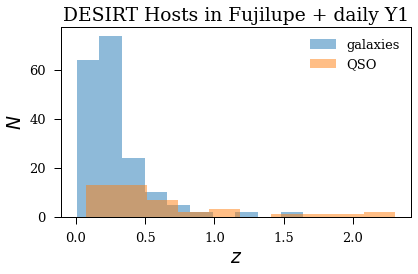

In [23]:
plt_style()
from matplotlib import rc
rc("text", usetex=False)

plt.hist(zhosts[(zhosts>-1) & (ztype=='GALAXY') & (zwarn==0)], label='galaxies',alpha=0.5)
plt.hist(zhosts[(zhosts>-1) & (ztype=='QSO') & (zwarn==0)], label='QSO',alpha=0.5)

plt.legend()
plt.ylabel('$N$')
plt.xlabel('$z$')
plt.title('DESIRT Hosts in Fujilupe + daily Y1')
plt.tight_layout()
plt.savefig('DESIRT_hosts_fujilupe_Y1_dndz.png',dpi=200)

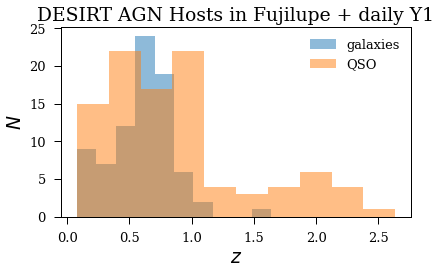

In [24]:
plt_style()
from matplotlib import rc
rc("text", usetex=False)

plt.hist(zhosts_agn[(zhosts_agn>-1) & (ztype_agn=='GALAXY') & (zwarn_agn==0)], label='galaxies',alpha=0.5)
plt.hist(zhosts_agn[(zhosts_agn>-1) & (ztype_agn=='QSO') & (zwarn_agn==0)], label='QSO',alpha=0.5)

plt.legend()
plt.ylabel('$N$')
plt.xlabel('$z$')
plt.title('DESIRT AGN Hosts in Fujilupe + daily Y1')
plt.tight_layout()
plt.savefig('DESIRT_agn_hosts_fujilupe_Y1_dndz.png',dpi=200)

In [25]:
print("Final number of host: ",zhosts[(zhosts>-1)].shape, zhosts_agn[(zhosts_agn>-1)].shape)

Final number of host:  (238,) (182,)


In [31]:
transients_matches_all_info.dtype

dtype('<U40')

In [40]:
#Now saving the matches

header = 'TransientID, HOST_TARGETID, REDSHIFT, CHI2, SPECTYPE, ZWARN'
fmt = '%s'#'%30s %i  %10.6f %i %s %i'
zwarn_int = np.array([int(zwarn[k]) for k in range(zwarn.shape[0])])
mask = (transid!='NULL') & (zwarn_int<10)
transients_matches_all_info = np.column_stack((transid[mask],desiids[mask],zhosts[mask],zchi[mask],ztype[mask],zwarn[mask]))

np.savetxt('DESIRT_hosts_redshifts_fujilupe_Y1.csv', transients_matches_all_info, delimiter =',',fmt = fmt, header = header)



In [33]:
#Now saving the matches

header = 'TransientID, HOST_TARGETID, REDSHIFT, CHI2, SPECTYPE, ZWARN'
fmt = '%s'#'%30s %i  %10.6f %i %s %i'
zwarn_agn_int = np.array([int(zwarn_agn[k]) for k in range(zwarn_agn.shape[0])])
mask_agn = (transid_agn!='NULL') & (zwarn_agn_int<10)
transients_agn_matches_all_info = np.column_stack((transid_agn[mask],desiids_agn[mask],zhosts_agn[mask],zchi_agn[mask],ztype_agn[mask],zwarn_agn[mask]))

np.savetxt('DESIRT_agn_hosts_redshifts_fujilupe_Y1.csv', transients_agn_matches_all_info, delimiter =',',fmt = fmt, header = header)



array([['A202103221408412p002445', '39627800365239566',
        '0.3237484824681474', '14082', 'QSO', '0'],
       ['A202103221408578m005300', '39627764126454772',
        '0.6358600244900215', '1365', 'QSO', '0'],
       ['A202103221411363p015959', '39627836616609456',
        '0.2687428701336574', '4028', 'GALAXY', '0'],
       ...,
       ['T202106021424518p001145', '39627794392552489',
        '0.3242990269657905', '84', 'GALAXY', '0'],
       ['T202106021426332m010342', '39627764201949829',
        '0.05590392451470623', '8258', 'GALAXY', '0'],
       ['T202106021449003p003225', '39627800537202736',
        '0.1387304613916705', '119', 'GALAXY', '0']], dtype='<U40')

### Plotting abs mag 

Text(0, 0.5, 'dec')

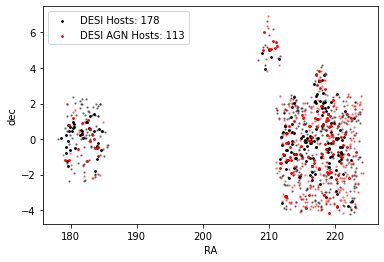

In [41]:
nhosts = decam_transients['RA-PSEUDO-HOST'][zhosts>-1].shape[0] 
nhosts_agn = decam_transients_agn['RA-PSEUDO-HOST'][zhosts_agn>-1].shape[0]

c='k'
plt.scatter(decam_transients['RA-PSEUDO-HOST'],decam_transients['DEC-PSEUDO-HOST'],s=2,c=c,alpha=0.4)
plt.scatter(decam_transients['RA-PSEUDO-HOST'][zhosts>-1],\
            decam_transients['DEC-PSEUDO-HOST'][zhosts>-1],c=c,s=3, label='DESI Hosts: '+str(nhosts))

c='red'
plt.scatter(decam_transients_agn['RA-PSEUDO-HOST'],decam_transients_agn['DEC-PSEUDO-HOST'],c=c,alpha=0.4,s=2)
plt.scatter(decam_transients_agn['RA-PSEUDO-HOST'][zhosts_agn>-1],\
            decam_transients_agn['DEC-PSEUDO-HOST'][zhosts_agn>-1],c=c,s=3, label='DESI AGN Hosts: '+str(nhosts_agn))

plt.legend()
plt.xlabel('RA')
plt.ylabel('dec')

In [35]:
decam_transients['RA-PSEUDO-HOST'][zhosts>-1].shape, decam_transients_agn['RA-PSEUDO-HOST'][zhosts_agn>-1].shape

((178,), (113,))

In [3]:
import numpy as np
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

magpeak=18
magpeak - 5. * np.log10(40.*1e6) + 5., magpeak - 5. * np.log10(40.*1e5)

dist= cosmo.luminosity_distance(0.5663)
21.45 - 5. * np.log10(dist.value*1e6) + 5.

-21.136799956870195

In [ ]:
#Plot abs mags for matches
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

peak_absmag =  np.full((decam_transients['RA-PSEUDO-HOST'].shape[0],3), -99.9, dtype=float)
peak_mag = np.full((decam_transients['RA-PSEUDO-HOST'].shape[0],3), -99.9, dtype=float)

objids=decam_transients['ObjectID'][zhosts>-1]
filternames=[b'g',b'r',b'z']

for objid in objids:
    
    idx_obj = decam_transients['ObjectID']==objid
    decam_path = '/global/cfs/cdirs/desi/science/td/DECam/imaging/LCData_Legacy/'+str(objid)+'/lc*csv'
    lc_file = glob.glob(decam_path)

    d= np.genfromtxt(lc_file[0], delimiter=',', names=True, dtype=None)  
    
    ifilter=0
    for filtername in filternames:
        idx= (d['filter']==filtername) & (d['mag']>15)
        try:
            magpeak = d['mag'][idx].min()

            z=zhosts[idx_obj]
            dist= cosmo.luminosity_distance(z)
            absmag = magpeak - 5. * np.log10(dist.value*1e6) + 5.

            peak_absmag[idx_obj,ifilter] = absmag
            peak_mag[idx_obj,ifilter] = magpeak
            ifilter+=1
        except:
            print("Error for ", objid, " in ", filtername ," band")

<ipython-input-17-ec4da481f5ab>:17: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  d= np.genfromtxt(lc_file[0], delimiter=',', names=True, dtype=None)
<ipython-input-17-ec4da481f5ab>:27: RuntimeWarning: invalid value encountered in log10
  absmag = magpeak - 5. * np.log10(dist.value*1e6) + 5.


Error for  A202104151437519p005515  in  b'z'  band
Error for  A202104271157060m002713  in  b'g'  band
Error for  A202104271157570m011240  in  b'g'  band
Error for  A202104271159003p002625  in  b'g'  band
Error for  A202104271200504p002724  in  b'g'  band
Error for  A202104271201259p003735  in  b'g'  band
Error for  A202104271201320p005732  in  b'g'  band
Error for  A202104271201578p004151  in  b'g'  band
Error for  A202104271202016p005013  in  b'g'  band
Error for  A202104271206254p003103  in  b'g'  band
Error for  A202104271207038p001622  in  b'g'  band
Error for  A202104271207362p000507  in  b'g'  band
Error for  A202104271211446p011805  in  b'g'  band
Error for  A202104271213476p012531  in  b'g'  band
Error for  A202105061400244p050138  in  b'g'  band
Error for  A202105061406055p042910  in  b'g'  band
Error for  A202105241154142p000516  in  b'g'  band
Error for  A202105241158256p004820  in  b'g'  band
Error for  A202105241159263p004157  in  b'g'  band
Error for  A202105241205187p001

In [166]:
filtername, ifilter

(b'z', 3)

In [177]:
for all_objid in decam_transients['ObjectID']:
    
    idx_obj = decam_transients['ObjectID']==all_objid
    decam_path = '/global/cfs/cdirs/desi/science/td/DECam/imaging/LCData_Legacy/'+str(all_objid)+'/lc*csv'
    lc_file = glob.glob(decam_path)

    d= np.genfromtxt(lc_file[0], delimiter=',', names=True, dtype=None)  
    
    ifilter=0
    for filtername in filternames:
        idx= (d['filter']==filtername) & (d['mag']>15)
        
        #magpeak = d['mag'][idx].min()
        #peak_mag[idx_obj,ifilter] = magpeak
        
        #ifilter+=1
        try:
            magpeak = d['mag'][idx].min()

            peak_mag[idx_obj,ifilter] = magpeak
            ifilter+=1
        except:
            test=1
            #print("Error for ", objid, " in ", filtername ," band")

<ipython-input-177-4c6a73d5683f>:7: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  d= np.genfromtxt(lc_file[0], delimiter=',', names=True, dtype=None)


No handles with labels found to put in legend.


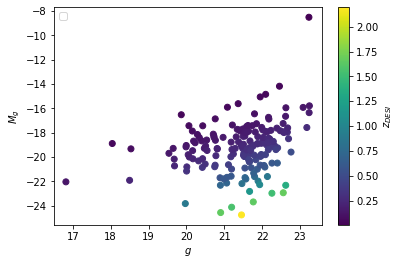

In [18]:
plt.scatter(peak_mag[peak_absmag[:,0]>-90,0],peak_absmag[peak_absmag[:,0]>-90,0],c=zhosts[peak_absmag[:,0]>-90])
plt.colorbar(label='$z_{DESI}$')
plt.xlabel('$g$')
plt.ylabel('$M_g$')
plt.legend()


No handles with labels found to put in legend.


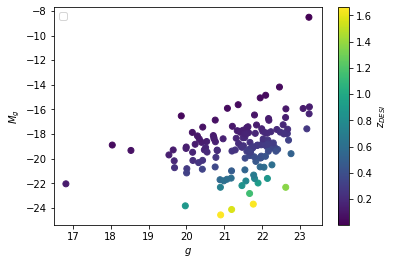

In [20]:
idx_gals = (peak_absmag[:,0]>-90) & (ztype=='GALAXY') 

plt.scatter(peak_mag[idx_gals,0],peak_absmag[idx_gals,0],c=zhosts[idx_gals])
plt.colorbar(label='$z_{DESI}$')
plt.xlabel('$g$')
plt.ylabel('$M_g$')
plt.legend()


No handles with labels found to put in legend.


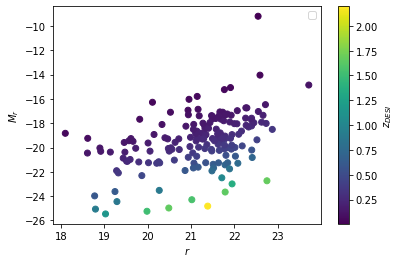

In [189]:

plt.scatter(peak_mag[peak_absmag[:,1]>-30,1],peak_absmag[peak_absmag[:,1]>-30,1],c=zhosts[peak_absmag[:,1]>-30])
plt.colorbar(label='$z_{DESI}$')
plt.xlabel('$r$')
plt.ylabel('$M_r$')
plt.legend()


No handles with labels found to put in legend.


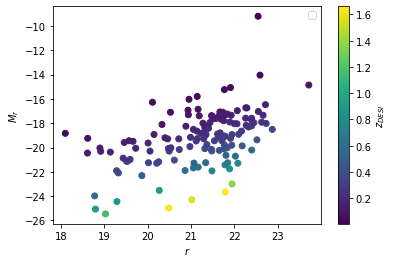

In [21]:
idx_gals = (peak_absmag[:,1]>-90) & (ztype=='GALAXY') 

plt.scatter(peak_mag[idx_gals,1],peak_absmag[idx_gals,1],c=zhosts[idx_gals])
plt.colorbar(label='$z_{DESI}$')
plt.xlabel('$r$')
plt.ylabel('$M_r$')
plt.legend()

In [26]:
idx_gals = (peak_absmag[:,1]>-90) & (peak_absmag[:,1]<-22) & (ztype=='GALAXY') 
decam_transients['ObjectID'][idx_gals], zhosts[idx_gals]

(31     A202103221432532p005029
 45     A202103221444205m002735
 91     A202104061432308p015321
 130    A202104121440520p000156
 131    A202104121441090p000144
 139    A202104151436246m002825
 182    A202104271213476p012531
 288    A202105301428199p020404
 362    T202104061410268m003625
 395    T202104061437125m010012
 518    T202105271214387m014717
 Name: ObjectID, dtype: object,
 array([0.91448524, 1.65334003, 0.87338165, 0.35942027, 0.48355401,
        1.1553413 , 1.66133865, 0.603275  , 1.36705493, 0.89114651,
        1.57056006]))

No handles with labels found to put in legend.


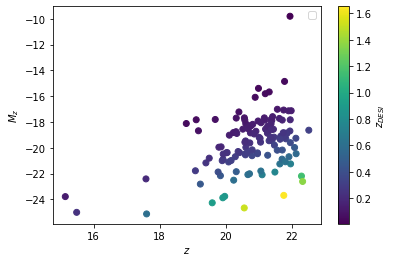

In [190]:
plt.scatter(peak_mag[peak_absmag[:,2]>-30,2],peak_absmag[peak_absmag[:,2]>-30,2],c=zhosts[peak_absmag[:,2]>-30])
plt.colorbar(label='$z_{DESI}$')
plt.xlabel('$z$')
plt.ylabel('$M_z$')
plt.legend()


No handles with labels found to put in legend.


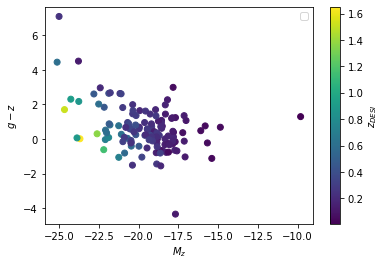

In [191]:
ifilter1=0
ifilter2=2
sel = (peak_absmag[:,ifilter1]>-30) & (peak_absmag[:,ifilter2]>-30)
plt.scatter(peak_absmag[sel,ifilter2],peak_mag[sel,ifilter1]- peak_mag[sel,ifilter2],c=zhosts[sel])
plt.colorbar(label='$z_{DESI}$')
plt.xlabel('$M_z$')
plt.ylabel('$g-z$')
plt.legend()



In [193]:
40e6/1e6


40.0

No handles with labels found to put in legend.


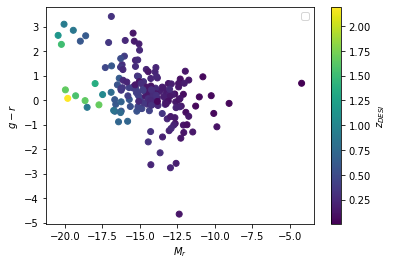

In [157]:
ifilter1=0
ifilter2=1

sel = (peak_absmag[:,ifilter1]>-30) & (peak_absmag[:,ifilter2]>-30)

plt.scatter(peak_absmag[sel,ifilter2],peak_mag[sel,ifilter1]- peak_mag[sel,ifilter2],c=zhosts[sel])
plt.colorbar(label='$z_{DESI}$')
plt.xlabel('$M_r$')
plt.ylabel('$g-r$')
plt.legend()



No handles with labels found to put in legend.


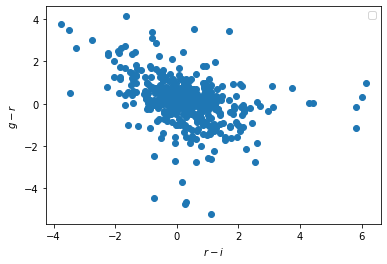

In [178]:
ifilter1=0
ifilter2=1
ifilter3=2

sel = (peak_mag[:,ifilter1]>-30) & (peak_mag[:,ifilter2]>-30) & (peak_mag[:,ifilter3]>-30)

plt.scatter(peak_mag[sel,ifilter2]- peak_mag[sel,ifilter3],peak_mag[sel,ifilter1]- peak_mag[sel,ifilter2]) #,c=zhosts[sel])

plt.xlabel('$r-i$')
plt.ylabel('$g-r$')
plt.legend()



In [1]:
import requests

def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    



download_file_from_google_drive('1eELRrSWnNFKPaErHx5k5KVcEaY7WQBz3', \
                                '/global/cfs/cdirs/desi/science/td/DECam/imaging/All_AGN.tar.gz')

### Match to TNS

In [1]:
#!/usr/bin/env python
"""Access TNS using a URL GET. Save the data to CSV.
Adapted from the tns_watcher script by Dima Duev,
https://github.com/dmitryduev/kowalski/blob/master/kowalski/tns_watcher.py
which was ported here by Anna Ho.
Example usage:
> python tns_download.py --classified -n 3
This will download 3 months of alerts classified as SNe and save them to CSV.
"""

import argparse
import requests
import pandas as pd
import io


def download_data(args):
    """Download data from the Transient Name Server.
    Parameters
    ----------
    args : dict
        Dictionary of key-value pairs to pass to the TNS URL GET query.
    Returns
    -------
    tns_data : pandas.DataFrame
        Accumulated data tables from TNS.
    """

    # Build up the URL GET.
    base_url = 'https://www.wis-tns.org/search?format=csv'
    for k, v in args.items():
        if v is None:
            continue
        base_url = f'{base_url}&{k}={v}'

    # User-agent needed for request to go through.
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.55 Safari/537.36'
    }

    # Start the request. Set up a loop through pages returned by TNS.
    # There is a maximum of 500 results per page.
    loop = True
    page = 0
    tns_data = None
    npage = 500
    
    while loop:
        url = f'{base_url}&num_page={npage}&page={page}'
        print(url)
        f = requests.get(url, headers=headers)
        data = pd.read_csv(io.StringIO(f.content.decode('utf-8')), error_bad_lines=False)
    
        # We're done if we have no data...
        if len(data) == 0:
            break
    
        # ...or if the data on this page is less than npage.
        loop = len(data) >= npage
    
        # Accumulate data from each page.
        if tns_data is None:
            tns_data = data
        else:
            tns_data = pd.concat([tns_data, data])
    
        page += 1

    return tns_data



In [ ]:
    p = argparse.ArgumentParser(description='TNS data access script',
            formatter_class=argparse.ArgumentDefaultsHelpFormatter)

    p.add_argument('--classified', dest='classified_sne',
                   default=None, const=1, nargs='?', type=int,
                   help='Require classification of alerts.')
    p.add_argument('-n', '--nperiod', dest='discovered_period_value', default=2,
                   help='Number of periods (days, weeks, months) to check for alerts.')
    p.add_argument('-u', '--units', dest='discovered_period_units', default='months',
                   choices=['days', 'weeks', 'months'],
                   help='Number of periods (days, weeks, months) to check for alerts.')
    p.add_argument('-o', '--output', dest='output', default='tns_search.csv',
                   help='Output CSV file from TNS query.')

    args = p.parse_args()

    # Clean up output arg so it's not passed to download_data.
    output = args.output
    del args.output

    # Access data and save to output.
    tns_data = download_data(vars(args))
    tns_data.to_csv(output)

    print(f'Saved {len(tns_data)} alerts to {output}')

In [ ]:
https://www.wis-tns.org/search?&discovered_period_value=1&discovered_period_units=months&unclassified_at=0&
classified_sne=0&include_frb=0&name=&name_like=0&isTNS_AT=all&public=all&
ra=0.1&decl=0.1&radius=1&coords_unit=arcsec
&reporting_groupid%5B%5D=null&groupid%5B%5D=null&classifier_groupid%5B%5D=null&objtype%5B%5D=null&at_type%5B%5D=null&date_start%5Bdate%5D=&date_end%5Bdate%5D=&discovery_mag_min=&discovery_mag_max=&internal_name=&discoverer=&classifier=&spectra_count=&redshift_min=&redshift_max=&hostname=&ext_catid=&ra_range_min=&ra_range_max=&decl_range_min=&decl_range_max=&discovery_instrument%5B%5D=null&classification_instrument%5B%5D=null&associated_groups%5B%5D=null&official_discovery=0&official_classification=0&at_rep_remarks=&class_rep_remarks=&frb_repeat=all&frb_repeater_of_objid=&frb_measured_redshift=0&frb_dm_range_min=&frb_dm_range_max=&frb_rm_range_min=&frb_rm_range_max=&frb_snr_range_min=&frb_snr_range_max=&frb_flux_range_min=&frb_flux_range_max=&num_page=50&display%5Bredshift%5D=1&display%5Bhostname%5D=1&display%5Bhost_redshift%5D=1&display%5Bsource_group_name%5D=1&display%5Bclassifying_source_group_name%5D=1&display%5Bdiscovering_instrument_name%5D=0&display%5Bclassifing_instrument_name%5D=0&display%5Bprograms_name%5D=0&display%5Binternal_name%5D=1&display%5BisTNS_AT%5D=0&display%5Bpublic%5D=1&display%5Bend_pop_period%5D=0&display%5Bspectra_count%5D=1&display%5Bdiscoverymag%5D=1&display%5Bdiscmagfilter%5D=1&display%5Bdiscoverydate%5D=1&display%5Bdiscoverer%5D=1&display%5Bremarks%5D=0&display%5Bsources%5D=0&display%5Bbibcode%5D=0&display%5Bext_catalogs%5D=0